In [1]:
import pandas as pd
from scipy.stats import binomtest

In [2]:
df = pd.read_csv("results/tc_collection_results.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19800 entries, 0 to 19799
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TC Collection       19800 non-null  object 
 1   Size Group          19800 non-null  int64  
 2   Vector Name         19800 non-null  object 
 3   Classifier          19800 non-null  object 
 4   AVG Accuracy        19800 non-null  float64
 5   AVG # missing URLs  19800 non-null  float64
 6   Vector Path         19800 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 1.1+ MB


In [3]:
df["coverage"] = 1 - df["AVG # missing URLs"] / df["Size Group"]

df["coverage"].describe()

count    19800.000000
mean         0.939838
std          0.069469
min          0.120000
25%          0.917000
50%          0.950667
75%          1.000000
max          1.000000
Name: coverage, dtype: float64

In [4]:
def get_embedding_type(test_name_short):
    breakdown = test_name_short.split('-')
    
    embedding_type = '-'.join(breakdown[0:-2])
    
    if embedding_type.startswith("non-rdf2vec-"):
        return embedding_type.replace("non-rdf2vec-", "")
    
    else:
        return str.upper(embedding_type).replace("RDF2VEC-", "RDF2vec$_{") + "}$"

def get_embedding_variant(test_name_short):
    breakdown = test_name_short.split('-')
    
    return  breakdown[-1].replace("autoencoded", "auto") + "-" + breakdown[-2]

df['embedding_type'] = df['Vector Name'].apply(get_embedding_type)
df['embedding_variant'] = df['Vector Name'].apply(get_embedding_variant)

print(df['embedding_type'].unique())
print(df['embedding_variant'].unique())

['RDF2vec$_{CBOW}$' 'RDF2vec$_{CBOW-OA}$' 'RDF2vec$_{SG}$'
 'RDF2vec$_{SG-OA}$' 'ComplEx' 'DistMult' 'RESCAL' 'RotatE' 'TransE-L1'
 'TransE-L2' 'TransR']
['original-200' 'avgbin-200' 'auto-128' 'auto-256' 'auto-512']


In [5]:
df[df["coverage"]<= 0.5][["TC Collection", "Size Group", "coverage", "embedding_type"]].drop_duplicates()

,TC Collection,Size Group,coverage,embedding_type
4094,tc02_hard,50,0.466667,RDF2vec$_{SG}$
16832,tc01_hard,50,0.220000,RDF2vec$_{SG}$
16854,tc01_hard,50,0.120000,RDF2vec$_{SG}$


In [6]:
df['rank'] = df[df['coverage']>=0.5].groupby(by=[
    'Vector Name', 
    'TC Collection', 
    'Size Group',
])['AVG Accuracy'].rank(
    method='first', 
    ascending=False,
)

df_bestscores = df[df['rank']==1.0].drop(columns=['rank', 'Vector Path']).sort_values(
    by=[
        'TC Collection', 
        'Size Group', 
        'AVG Accuracy'
    ], 
    ascending=False,
)

df_bestscores.describe()

,Size Group,AVG Accuracy,AVG # missing URLs,coverage
count,3295.000000,3295.000000,3295.000000,3295.000000
mean,1852.731411,0.794473,95.068655,0.940741
std,2235.883017,0.110476,177.214182,0.062899
min,50.000000,0.511606,0.000000,0.595000
25%,50.000000,0.706685,0.000000,0.917000
50%,500.000000,0.800000,9.500000,0.951850
75%,5000.000000,0.888588,103.041667,1.000000
max,5000.000000,0.992110,1162.000000,1.000000


In [7]:
def get_acc_loss(tc_collection, group_size, accuracy, embedding_type):
#     successes = round(group_size * accuracy)
    p = df_bestscores[
        (df_bestscores["TC Collection"]==tc_collection)
        & (df_bestscores["Size Group"]==group_size)
        & (df_bestscores["embedding_type"]==embedding_type)
        & (df_bestscores["embedding_variant"]=="original-200")
    ]["AVG Accuracy"].iloc[0]

    return p - accuracy

def calculate_pvalue(tc_collection, group_size, accuracy, embedding_type):
    successes = round(group_size * accuracy)
    p = get_acc_loss(tc_collection, group_size, accuracy, embedding_type) + accuracy

    return binomtest(successes, group_size, p, alternative='less').pvalue
    
df_bestscores["acc_loss"] = df_bestscores.apply(
    lambda x: get_acc_loss(
        x["TC Collection"], 
        x["Size Group"], 
        x["AVG Accuracy"], 
        x["embedding_type"],
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)
    
df_bestscores["pvalue_worse_than_original"] = df_bestscores.apply(
    lambda x: calculate_pvalue(
        x["TC Collection"], 
        x["Size Group"], 
        x["AVG Accuracy"], 
        x["embedding_type"],
    ) if x.embedding_variant!="original-200" else None, 
    axis=1,
)

alpha=0.05
df_bestscores["not_worse_than_original"] = df_bestscores["pvalue_worse_than_original"] >= alpha

df_bestscores[["pvalue_worse_than_original", "acc_loss"]].describe()

,pvalue_worse_than_original,acc_loss
count,2.636000e+03,2636.000000
mean,1.527078e-01,0.044599
std,2.414657e-01,0.041588
min,3.310240e-322,-0.121191
25%,3.175252e-12,0.021261
50%,5.462874e-03,0.038398
75%,2.396171e-01,0.063026
max,1.000000e+00,0.240497


In [8]:
df_bestscores["TC Collection"] = df_bestscores["TC Collection"].str.replace("_", "-")

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')

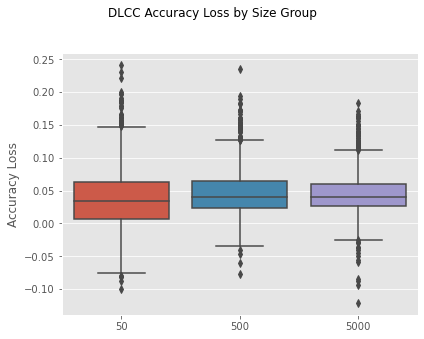

DLCC Accuracy Loss by Size Group in Figure \ref{fig:dlcc-acc-loss-sizegroup}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup.png}}
    \caption{DLCC Accuracy Loss by Size Group}
    \label{fig:dlcc-acc-loss-sizegroup}
\end{figure}


In [10]:
g = sns.catplot(
    data=df_bestscores[df_bestscores["embedding_variant"]!="original-200"], 
    x="Size Group", 
    y="acc_loss",
    kind="box",
    aspect=1.2,
)

g.set_axis_labels("", "Accuracy Loss")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('DLCC Accuracy Loss by Size Group')

plt.savefig("assets/dlcc-acc-loss-sizegroup.png")

plt.show()
    
print("DLCC Accuracy Loss by Size Group in Figure \\ref{fig:dlcc-acc-loss-sizegroup}.\n")
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup.png}}")
print("    \caption{DLCC Accuracy Loss by Size Group}")
print("    \label{fig:dlcc-acc-loss-sizegroup}")
print("\end{figure}")

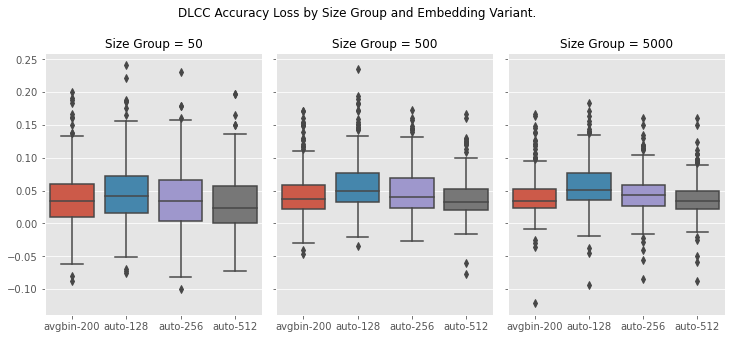

DLCC accuracy loss by size group and embedding variant in Figure \ref{fig:dlcc-acc-loss-sizegroup-variant}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-variant.png}}
    \caption{DLCC Accuracy Loss by Size Group and Embedding Variant}
    \label{fig:dlcc-acc-loss-sizegroup-variant}
\end{figure}


In [11]:
g = sns.catplot(
    data=df_bestscores[df_bestscores["embedding_variant"]!="original-200"], 
    x="embedding_variant", 
    y="acc_loss",
    kind="box",
    col="Size Group",
    aspect=0.7,
    order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
)

g.set_axis_labels("", "")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('DLCC Accuracy Loss by Size Group and Embedding Variant.')

plt.savefig("assets/dlcc-acc-loss-sizegroup-variant.png")

plt.show()
    
print("DLCC accuracy loss by size group and embedding variant in Figure \\ref{fig:dlcc-acc-loss-sizegroup-variant}.\n")
print("\\begin{figure}[h!]")
print("    \centering")
print("    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-variant.png}}")
print("    \caption{DLCC Accuracy Loss by Size Group and Embedding Variant}")
print("    \label{fig:dlcc-acc-loss-sizegroup-variant}")
print("\end{figure}")

In [12]:
def reorganize_latex_table(latex_table):
    latex_table_split = latex_table.split("\n")
    
    latex_table_split[0] += "[h!]"
    caption = latex_table_split.pop(2)
    label = latex_table_split.pop(2)
    end_string = latex_table_split.pop(-1)
    end_table = latex_table_split.pop(-1)

    latex_table_split.extend([caption, label, end_table, end_string])
    return "\n".join(latex_table_split)

In [13]:
example_1 = """\begin{table}[h!]
\centering
\label{tab:dlcc-significantly-not-worse}
\begin{tabular}{lrrrr}
\toprule
{} &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
ComplEx             &          15 &        16 &        17 &        21 \\
DistMult            &          13 &        16 &        19 &        19 \\
RDF2vec$_{CBOW-OA}$ &          38 &        24 &        33 &        33 \\
RDF2vec$_{CBOW}$    &          40 &        25 &        30 &        32 \\
RDF2vec$_{SG-OA}$   &          24 &        22 &        24 &        26 \\
RDF2vec$_{SG}$      &          27 &        24 &        28 &        30 \\
RESCAL              &          24 &        24 &        26 &        19 \\
RotatE              &          27 &        21 &        19 &        28 \\
TransE-L1           &          22 &        19 &        20 &        26 \\
TransE-L2           &          27 &        20 &        22 &        29 \\
TransR              &          20 &        19 &        18 &        25 \\
\bottomrule
\end{tabular}
\caption{Count of DLCC classification datasets (out of 60) in which the best classifier 
of each binary embedding variant did not significantly underperfom the original one in accuracy. $\alpha=0.05$.}
\end{table}"""

example_2 = """\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01      &         0.860 &       0.774 &     0.766 &     0.784 &     0.791 \\
tc01-hard &         0.644 &       0.569 &     0.582 &     0.596 &     0.588 \\
tc02      &         0.870 &       0.753 &     0.767 &     0.772 &     0.774 \\
tc02-hard &         0.608 &       0.579 &     0.621 &     0.570 &     0.605 \\
tc03      &         0.877 &       0.787 &     0.786 &     0.798 &     0.808 \\
tc04      &         0.989 &       0.958 &     0.959 &     0.967 &     0.975 \\
tc04-hard &         0.934 &       0.878 &     0.883 &     0.891 &     0.905 \\
tc05      &         0.908 &       0.829 &     0.862 &     0.848 &     0.879 \\
tc06      &         0.990 &       0.962 &     0.959 &     0.968 &     0.975 \\
tc06-hard &         0.933 &       0.866 &     0.852 &     0.868 &     0.891 \\
tc07      &         0.967 &       0.874 &     0.885 &     0.920 &     0.930 \\
tc08      &         0.883 &       0.805 &     0.749 &     0.808 &     0.819 \\
tc09      &         0.884 &       0.821 &     0.821 &     0.847 &     0.861 \\
tc09-hard &         0.784 &       0.704 &     0.713 &     0.736 &     0.748 \\
tc10      &         0.941 &       0.777 &     0.800 &     0.837 &     0.849 \\
tc10-hard &         0.739 &       0.599 &     0.606 &     0.620 &     0.634 \\
tc11      &         0.948 &       0.897 &     0.848 &     0.922 &     0.850 \\
tc11-hard &         0.723 &       0.712 &     0.687 &     0.705 &     0.699 \\
tc12      &         0.889 &       0.768 &     0.766 &     0.808 &     0.826 \\
tc12-hard &         0.710 &       0.597 &     0.617 &     0.625 &     0.644 \\
\bottomrule
\end{tabular}
\caption{Accuracy scores for best classifier of each embedding variant in each test collection of size 5000 for ComplEx embeddings.}
\label{tab:dlcc-acc-complex-5000}
\end{table}"""

def highlight_best_scores(latex_table):
    latex_table_split = latex_table.split("\n")
    highlighted_latex_table_split = []

    for line in latex_table_split:
        line_split = line.strip("\\").split("&")
        if len(line_split) >= 4:
            line_values = []
            for value in line_split:
                if value.strip().replace(".", "").isnumeric():
                    line_values.append(float(value.strip())) 
            if len(line_values) >= 4:
                line_max_value = max(line_values)
                line_formatted = []
                for value in line_split: 
                    value_numeric = float(value.strip()) if value.strip().replace(".", "").isnumeric() else 0.0
                    new_value = "\t\\textbf{" + value.strip() + "}" if value_numeric==line_max_value else value
                    line_formatted.append(new_value)
                if len(line_formatted)>0:
                    highlighted_latex_table_split.append(" &".join(line_formatted) + " \\" + "\\")
            else:
                highlighted_latex_table_split.append(line)
        else:
                highlighted_latex_table_split.append(line)
    return "\n".join(highlighted_latex_table_split)

print(highlight_best_scores(example_1))

print(highlight_best_scores(example_2))

egin{table}[h!]
\centering
\label{tab:dlcc-significantly-not-worse}
egin{tabular}{lrrrr}
	oprule
{} &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \
\midrule
ComplEx              &          15  &        16  &        17  &	\textbf{21} \\
DistMult             &          13  &        16  &	\textbf{19} &	\textbf{19} \\
RDF2vec$_{CBOW-OA}$  &	\textbf{38} &        24  &        33  &        33  \\
RDF2vec$_{CBOW}$     &	\textbf{40} &        25  &        30  &        32  \\
RDF2vec$_{SG-OA}$    &          24  &        22  &        24  &	\textbf{26} \\
RDF2vec$_{SG}$       &          27  &        24  &        28  &	\textbf{30} \\
RESCAL               &          24  &        24  &	\textbf{26} &        19  \\
RotatE               &          27  &        21  &        19  &	\textbf{28} \\
TransE-L1            &          22  &        19  &        20  &	\textbf{26} \\
TransE-L2            &          27  &        20  &        22  &	\textbf{29} \\
TransR               &          20  &        19  &

In [14]:
caption="""Count of DLCC classification datasets (out of 60) in which the best classifier 
of each binary embedding variant did not significantly underperfom the original one in accuracy. $\\alpha=0.05$."""

df_sig_not_worst = pd.pivot_table(
    df_bestscores[df_bestscores["embedding_variant"]!="original-200"],
    values="not_worse_than_original", 
    index=["embedding_type"],
    columns=["embedding_variant"],
    aggfunc=lambda x: sum(x),
)

df_sig_not_worst_latex = reorganize_latex_table(df_sig_not_worst.to_latex(
    escape=False,
    index_names=False,
    label="tab:dlcc-significantly-not-worse",
    caption=caption,
    columns=[
        "avgbin-200",
        "auto-128",
        "auto-256",
        "auto-512",
    ]
))
print(highlight_best_scores(df_sig_not_worst_latex))

print(df_sig_not_worst.mean())

df_sig_not_worst

\begin{table}[h!]
\centering
\label{tab:dlcc-significantly-not-worse}
\begin{tabular}{lrrrr}
\toprule
{} &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
ComplEx              &          15  &        16  &        17  &	\textbf{21} \\
DistMult             &          13  &        16  &	\textbf{19} &	\textbf{19} \\
RDF2vec$_{CBOW-OA}$  &	\textbf{38} &        24  &        33  &        33  \\
RDF2vec$_{CBOW}$     &	\textbf{40} &        25  &        30  &        32  \\
RDF2vec$_{SG-OA}$    &          24  &        22  &        24  &	\textbf{26} \\
RDF2vec$_{SG}$       &          27  &        24  &        28  &	\textbf{30} \\
RESCAL               &          24  &        24  &	\textbf{26} &        19  \\
RotatE               &          27  &        21  &        19  &	\textbf{28} \\
TransE-L1            &          22  &        19  &        20  &	\textbf{26} \\
TransE-L2            &          27  &        20  &        22  &	\textbf{29} \\
TransR               &          20  &        1

embedding_variant,auto-128,auto-256,auto-512,avgbin-200
embedding_type,,,,
ComplEx,16,17,21,15
DistMult,16,19,19,13
RDF2vec$_{CBOW-OA}$,24,33,33,38
RDF2vec$_{CBOW}$,25,30,32,40
RDF2vec$_{SG-OA}$,22,24,26,24
RDF2vec$_{SG}$,24,28,30,27
RESCAL,24,26,19,24
RotatE,21,19,28,27
TransE-L1,19,20,26,22


In [15]:
caption="""Count of DLCC classification datasets (out of 60) in which the best classifier 
of each binary embedding variant did not significantly underperfom the original one in accuracy. $\\alpha=0.05$."""

df_sig_not_worst = pd.pivot_table(
    df_bestscores[
        (df_bestscores["embedding_variant"]!="original-200")
        & (df_bestscores["Size Group"]==5000)
    ],
    values="not_worse_than_original", 
    index=["embedding_type"],
    columns=["embedding_variant"],
    aggfunc=lambda x: sum(x),
)

df_sig_not_worst_latex = reorganize_latex_table(df_sig_not_worst.to_latex(
    escape=False,
    index_names=False,
    label="tab:dlcc-significantly-not-worse",
    caption=caption,
    columns=[
        "avgbin-200",
        "auto-128",
        "auto-256",
        "auto-512",
    ]
))
print(highlight_best_scores(df_sig_not_worst_latex))

print(df_sig_not_worst.mean())

df_sig_not_worst

\begin{table}[h!]
\centering
\label{tab:dlcc-significantly-not-worse}
\begin{tabular}{lrrrr}
\toprule
{} &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
ComplEx              &	\textbf{1} &	\textbf{1} &         0  &	\textbf{1} \\
DistMult             &           0  &         1  &         0  &	\textbf{2} \\
RDF2vec$_{CBOW-OA}$  &           3  &         3  &	\textbf{4} &         3  \\
RDF2vec$_{CBOW}$     &	\textbf{7} &         1  &         3  &         4  \\
RDF2vec$_{SG-OA}$    &	\textbf{2} &         0  &         1  &         1  \\
RDF2vec$_{SG}$       &           1  &         0  &	\textbf{3} &	\textbf{3} \\
RESCAL               &	\textbf{1} &         0  &	\textbf{1} &         0  \\
RotatE               &	\textbf{3} &         1  &         2  &         2  \\
TransE-L1            &	\textbf{1} &         0  &         0  &	\textbf{1} \\
	\textbf{TransE-L2} &	\textbf{0} &	\textbf{0} &	\textbf{0} &	\textbf{0} \\
TransR               &	\textbf{1} &         0  &	\textbf{1} &	\textb

embedding_variant,auto-128,auto-256,auto-512,avgbin-200
embedding_type,,,,
ComplEx,1,0,1,1
DistMult,1,0,2,0
RDF2vec$_{CBOW-OA}$,3,4,3,3
RDF2vec$_{CBOW}$,1,3,4,7
RDF2vec$_{SG-OA}$,0,1,1,2
RDF2vec$_{SG}$,0,3,3,1
RESCAL,0,1,0,1
RotatE,1,2,2,3
TransE-L1,0,0,1,1


In [16]:
def get_latex_table_acc(embedding_type, group_size):
    embedding_type_lower = str.lower(embedding_type).replace("_", "-")
    embedding_type_lower = embedding_type_lower.replace("{", "")
    embedding_type_lower = embedding_type_lower.replace("}", "")
    embedding_type_lower = embedding_type_lower.replace("$", "")
    
    return pd.pivot_table(
        df_bestscores[
            (df_bestscores["embedding_type"]==embedding_type)
            & (df_bestscores["Size Group"]==group_size)
        ], 
        values="AVG Accuracy", 
        index=["TC Collection"],
        columns=["embedding_variant"],
        aggfunc="max",
    ).to_latex(
        float_format="%.3f",
        escape=False,
        index_names=False,
        label=f"tab:dlcc-acc-{embedding_type_lower}-{group_size}",
        caption=f"Accuracy scores for best classifier of each embedding variant in each test collection of size {group_size} for {embedding_type} embeddings.",
        columns=[
            "original-200",
            "avgbin-200",
            "auto-128",
            "auto-256",
            "auto-512",
        ]
    )

In [17]:
embedding_type = "ComplEx"
group_size = 5000

latex_table_print = highlight_best_scores(reorganize_latex_table(get_latex_table_acc(embedding_type, group_size)))
# print(highlight_best_scores(df_sig_not_worst_latex))


print(embedding_type + f" {group_size}" + "\n\n" + latex_table_print + "\n\n")

print(highlight_best_scores(latex_table_print))

df_bestscores[
    (df_bestscores["embedding_type"]==embedding_type)
    & (df_bestscores["Size Group"]==group_size)
    & (df_bestscores["embedding_variant"]!="original-200")
].drop(columns=[
    "Size Group",
    "embedding_type",
    "embedding_variant",
    "pvalue_worse_than_original",
])

ComplEx 5000

\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.860} &       0.774  &     0.766  &     0.784  &     0.791  \\
tc01-hard  &	\textbf{0.644} &       0.569  &     0.582  &     0.596  &     0.588  \\
tc02       &	\textbf{0.870} &       0.753  &     0.767  &     0.772  &     0.774  \\
tc02-hard  &         0.608  &       0.579  &	\textbf{0.621} &     0.570  &     0.605  \\
tc03       &	\textbf{0.877} &       0.787  &     0.786  &     0.798  &     0.808  \\
tc04       &	\textbf{0.989} &       0.958  &     0.959  &     0.967  &     0.975  \\
tc04-hard  &	\textbf{0.934} &       0.878  &     0.883  &     0.891  &     0.905  \\
tc05       &	\textbf{0.908} &       0.829  &     0.862  &     0.848  &     0.879  \\
tc06       &	\textbf{0.990} &       0.962  &     0.959  &     0.968  &     0.975  \\
tc06-hard  &	\textbf{0.933} &       0.866  &     0.852  &     0.868  &    

,TC Collection,Vector Name,Classifier,AVG Accuracy,AVG # missing URLs,coverage,acc_loss,not_worse_than_original
19463,tc12-hard,non-rdf2vec-ComplEx-512-autoencoded,Multi_Layer_Perceptron,0.644226,199.666667,0.960067,0.066007,False
19452,tc12-hard,non-rdf2vec-ComplEx-256-autoencoded,Multi_Layer_Perceptron,0.624986,199.666667,0.960067,0.085248,False
19331,tc12-hard,non-rdf2vec-ComplEx-128-autoencoded,SVM,0.617070,199.666667,0.960067,0.093163,False
19375,tc12-hard,non-rdf2vec-ComplEx-200-avgbin,Random_Forrest,0.596594,0.000000,1.000000,0.113639,False
18473,tc12,non-rdf2vec-ComplEx-512-autoencoded,Multi_Layer_Perceptron,0.825717,333.333333,0.933333,0.063366,False
...,...,...,...,...,...,...,...,...
17395,tc01-hard,non-rdf2vec-ComplEx-200-avgbin,Random_Forrest,0.568849,0.000000,1.000000,0.074993,False
16493,tc01,non-rdf2vec-ComplEx-512-autoencoded,Multi_Layer_Perceptron,0.791476,424.000000,0.915200,0.068173,False
16482,tc01,non-rdf2vec-ComplEx-256-autoencoded,Multi_Layer_Perceptron,0.784329,424.000000,0.915200,0.075319,False
16405,tc01,non-rdf2vec-ComplEx-200-avgbin,Random_Forrest,0.774308,0.000000,1.000000,0.085341,False


\subsubsection{RDF2vec$_{CBOW}$}
\label{subsubsec:dlcc-results-rdf2vec-cbow} 

DLCC Accuracy Loss (all Size Groups) for RDF2vec$_{CBOW}$ Embeddings in Figure \ref{fig:dlcc-acc-loss-rdf2vec-cbow}.

\begin{figure}[h!]
    \centering
    \includegraphics[width=0.85\linewidth]{assets/dlcc-acc-loss-rdf2vec-cbow.png}
    \caption{DLCC Accuracy Loss for RDF2vec$_{CBOW}$ Embeddings}
    \label{fig:dlcc-acc-loss-rdf2vec-cbow}
\end{figure}



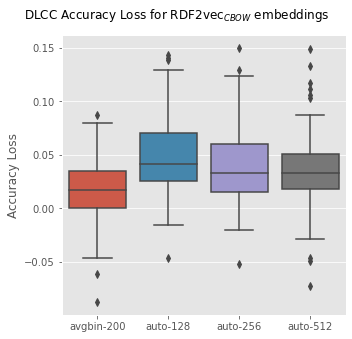

DLCC Accuracy Loss by Size Group for RDF2vec$_{CBOW}$ Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-rdf2vec-cbow}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-rdf2vec-cbow.png}}
    \caption{DLCC Accuracy Loss by Size Group for RDF2vec$_{CBOW}$ Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-rdf2vec-cbow}
\end{figure}


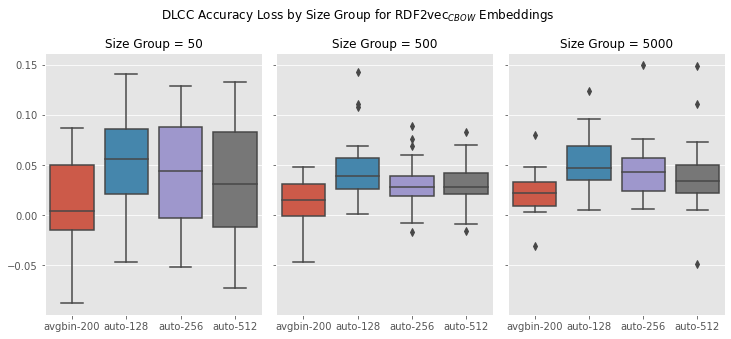

Accuracy scores for RDF2vec$_{CBOW}$ Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-rdf2vec-cbow-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.777} &       0.756  &     0.737  &     0.747  &     0.750  \\
tc01-hard  &	\textbf{0.646} &       0.615  &     0.607  &     0.622  &     0.608  \\
tc02       &	\textbf{0.865} &       0.785  &     0.832  &     0.850  &     0.861  \\
tc02-hard  &         0.621  &       0.652  &     0.616  &     0.613  &	\textbf{0.670} \\
tc03       &	\textbf{0.849} &       0.826  &     0.796  &     0.794  &     0.813  \\
tc04       &	\textbf{0.702} &       0.663  &     0.640  &     0.657  &     0.668  \\
tc04-hard  &	\textbf{0.681} &       0.671  &     0.658  &     0.675  &     0.674  \\
tc05       &	\textbf{0.773} &       0.765  &     0.648  &     0.704  &     0.661  \\
tc06       &	\textbf{0.694} &       0.6

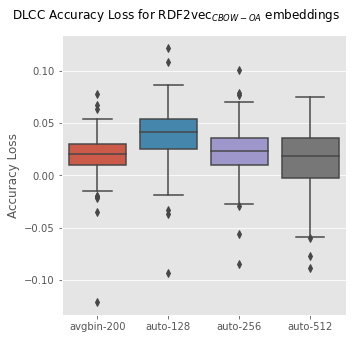

DLCC Accuracy Loss by Size Group for RDF2vec$_{CBOW-OA}$ Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-rdf2vec-cbow-oa}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-rdf2vec-cbow-oa.png}}
    \caption{DLCC Accuracy Loss by Size Group for RDF2vec$_{CBOW-OA}$ Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-rdf2vec-cbow-oa}
\end{figure}


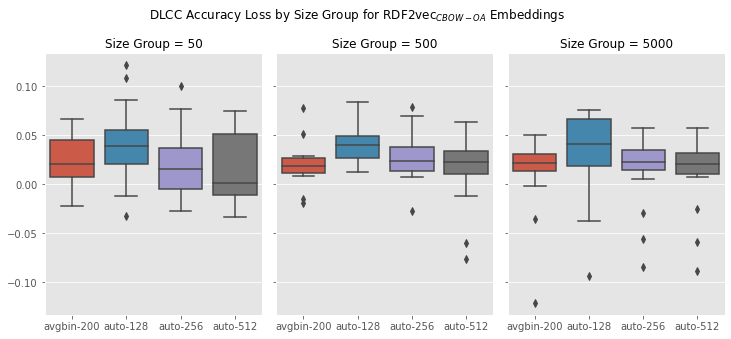

Accuracy scores for RDF2vec$_{CBOW-OA}$ Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-rdf2vec-cbow-oa-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.871} &       0.835  &     0.826  &     0.836  &     0.842  \\
tc01-hard  &	\textbf{0.888} &       0.841  &     0.818  &     0.855  &     0.859  \\
tc02       &	\textbf{0.956} &       0.927  &     0.887  &     0.934  &     0.919  \\
tc02-hard  &         0.772  &       0.774  &     0.791  &     0.828  &	\textbf{0.832} \\
tc03       &	\textbf{0.902} &       0.852  &     0.832  &     0.880  &     0.863  \\
tc04       &	\textbf{0.874} &       0.861  &     0.861  &     0.868  &     0.863  \\
tc04-hard  &	\textbf{0.992} &       0.975  &     0.974  &     0.982  &     0.984  \\
tc05       &	\textbf{0.905} &       0.885  &     0.838  &     0.875  &     0.897  \\
tc06       &	\textbf{0.850} &    

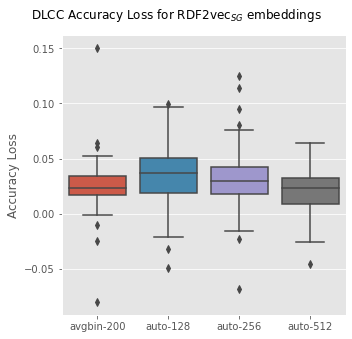

DLCC Accuracy Loss by Size Group for RDF2vec$_{SG}$ Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-rdf2vec-sg}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-rdf2vec-sg.png}}
    \caption{DLCC Accuracy Loss by Size Group for RDF2vec$_{SG}$ Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-rdf2vec-sg}
\end{figure}


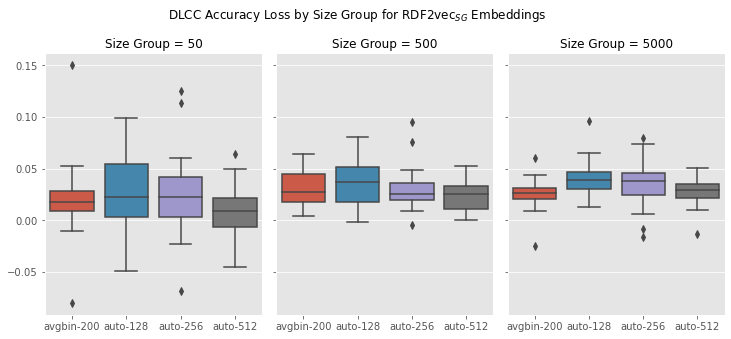

Accuracy scores for RDF2vec$_{SG}$ Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-rdf2vec-sg-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.913} &       0.891  &     0.873  &     0.875  &     0.886  \\
tc01-hard  &	\textbf{0.681} &       0.660  &     0.653  &     0.656  &     0.665  \\
tc02       &	\textbf{0.953} &       0.926  &     0.921  &     0.904  &     0.922  \\
tc02-hard  &	\textbf{0.637} &       0.620  &     0.618  &     0.607  &     0.601  \\
tc03       &	\textbf{0.949} &       0.926  &     0.908  &     0.899  &     0.922  \\
tc04       &	\textbf{0.958} &       0.933  &     0.917  &     0.913  &     0.929  \\
tc04-hard  &	\textbf{0.961} &       0.917  &     0.904  &     0.911  &     0.918  \\
tc05       &	\textbf{0.987} &       0.966  &     0.960  &     0.948  &     0.974  \\
tc06       &	\textbf{0.956} &       0.929  &   

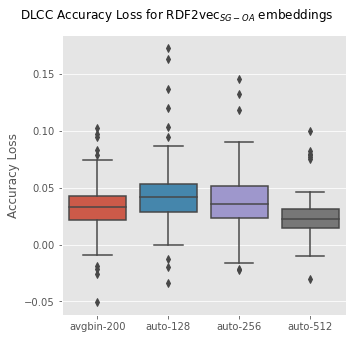

DLCC Accuracy Loss by Size Group for RDF2vec$_{SG-OA}$ Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-rdf2vec-sg-oa}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-rdf2vec-sg-oa.png}}
    \caption{DLCC Accuracy Loss by Size Group for RDF2vec$_{SG-OA}$ Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-rdf2vec-sg-oa}
\end{figure}


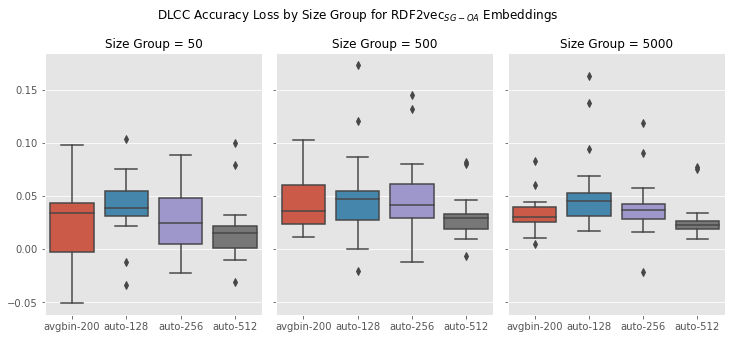

Accuracy scores for RDF2vec$_{SG-OA}$ Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-rdf2vec-sg-oa-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.937} &       0.898  &     0.868  &     0.891  &     0.903  \\
tc01-hard  &	\textbf{0.878} &       0.818  &     0.715  &     0.788  &     0.803  \\
tc02       &	\textbf{0.961} &       0.937  &     0.916  &     0.925  &     0.936  \\
tc02-hard  &	\textbf{0.794} &       0.755  &     0.700  &     0.758  &     0.774  \\
tc03       &	\textbf{0.961} &       0.932  &     0.910  &     0.917  &     0.939  \\
tc04       &	\textbf{0.969} &       0.943  &     0.937  &     0.936  &     0.946  \\
tc04-hard  &	\textbf{0.983} &       0.949  &     0.931  &     0.942  &     0.960  \\
tc05       &	\textbf{0.991} &       0.960  &     0.974  &     0.963  &     0.977  \\
tc06       &	\textbf{0.964} &       0.936

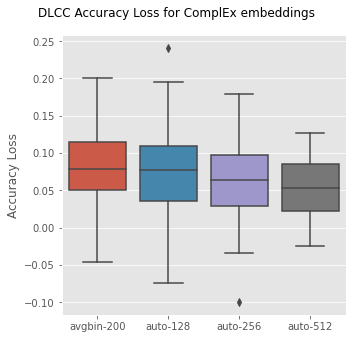

DLCC Accuracy Loss by Size Group for ComplEx Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-complex}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-complex.png}}
    \caption{DLCC Accuracy Loss by Size Group for ComplEx Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-complex}
\end{figure}


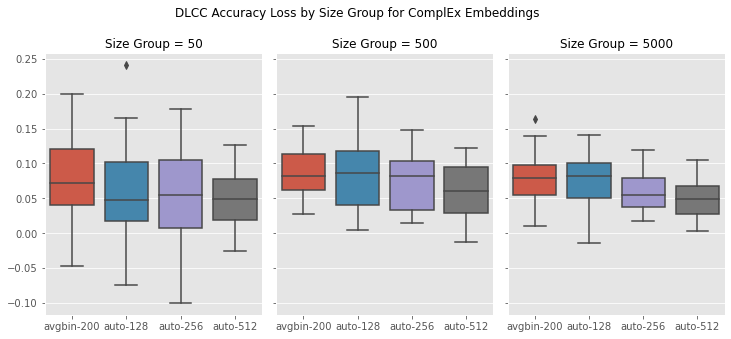

Accuracy scores for ComplEx Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-complex-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.860} &       0.774  &     0.766  &     0.784  &     0.791  \\
tc01-hard  &	\textbf{0.644} &       0.569  &     0.582  &     0.596  &     0.588  \\
tc02       &	\textbf{0.870} &       0.753  &     0.767  &     0.772  &     0.774  \\
tc02-hard  &         0.608  &       0.579  &	\textbf{0.621} &     0.570  &     0.605  \\
tc03       &	\textbf{0.877} &       0.787  &     0.786  &     0.798  &     0.808  \\
tc04       &	\textbf{0.989} &       0.958  &     0.959  &     0.967  &     0.975  \\
tc04-hard  &	\textbf{0.934} &       0.878  &     0.883  &     0.891  &     0.905  \\
tc05       &	\textbf{0.908} &       0.829  &     0.862  &     0.848  &     0.879  \\
tc06       &	\textbf{0.990} &       0.962  &     0.95

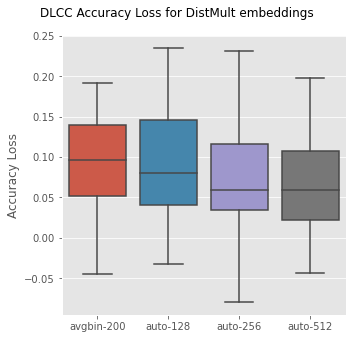

DLCC Accuracy Loss by Size Group for DistMult Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-distmult}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-distmult.png}}
    \caption{DLCC Accuracy Loss by Size Group for DistMult Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-distmult}
\end{figure}


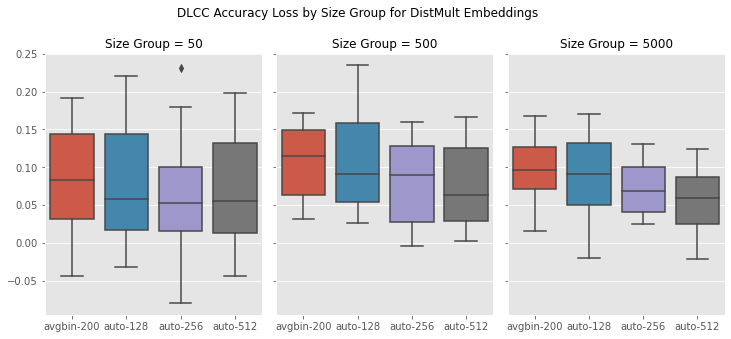

Accuracy scores for DistMult Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-distmult-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.872} &       0.751  &     0.757  &     0.773  &     0.783  \\
tc01-hard  &	\textbf{0.646} &       0.568  &     0.572  &     0.572  &     0.580  \\
tc02       &	\textbf{0.855} &       0.749  &     0.685  &     0.769  &     0.776  \\
tc02-hard  &         0.622  &       0.607  &     0.512  &     0.587  &	\textbf{0.630} \\
tc03       &	\textbf{0.891} &       0.765  &     0.779  &     0.788  &     0.810  \\
tc04       &	\textbf{0.983} &       0.938  &     0.947  &     0.958  &     0.966  \\
tc04-hard  &	\textbf{0.917} &       0.866  &     0.868  &     0.873  &     0.879  \\
tc05       &	\textbf{0.904} &       0.805  &     0.853  &     0.865  &     0.877  \\
tc06       &	\textbf{0.984} &       0.938  &     0.

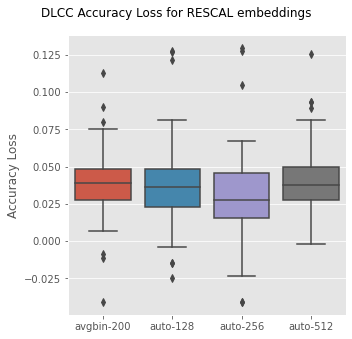

DLCC Accuracy Loss by Size Group for RESCAL Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-rescal}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-rescal.png}}
    \caption{DLCC Accuracy Loss by Size Group for RESCAL Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-rescal}
\end{figure}


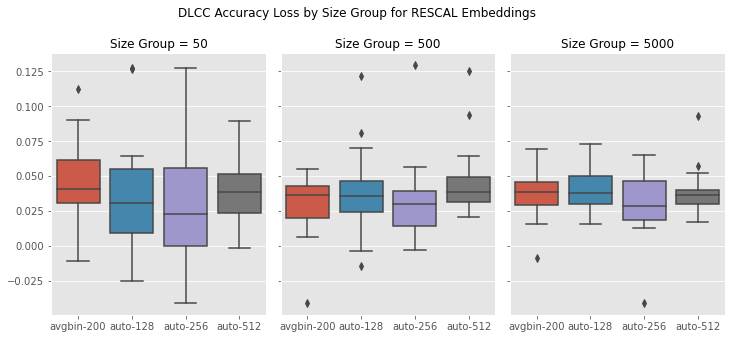

Accuracy scores for RESCAL Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-rescal-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.965} &       0.913  &     0.907  &     0.917  &     0.912  \\
tc01-hard  &	\textbf{0.835} &       0.780  &     0.792  &     0.801  &     0.810  \\
tc02       &	\textbf{0.901} &       0.857  &     0.841  &     0.847  &     0.866  \\
tc02-hard  &         0.729  &       0.738  &     0.704  &	\textbf{0.770} &     0.693  \\
tc03       &	\textbf{0.949} &       0.907  &     0.892  &     0.904  &     0.912  \\
tc04       &	\textbf{0.990} &       0.958  &     0.955  &     0.960  &     0.955  \\
tc04-hard  &	\textbf{0.915} &       0.845  &     0.842  &     0.850  &     0.822  \\
tc05       &	\textbf{0.909} &       0.878  &     0.880  &     0.883  &     0.872  \\
tc06       &	\textbf{0.990} &       0.961  &     0.959 

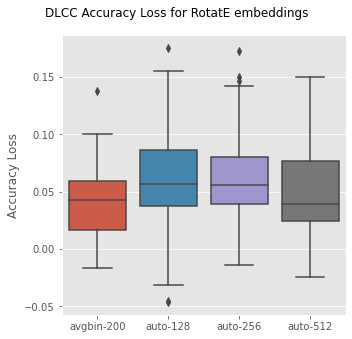

DLCC Accuracy Loss by Size Group for RotatE Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-rotate}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-rotate.png}}
    \caption{DLCC Accuracy Loss by Size Group for RotatE Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-rotate}
\end{figure}


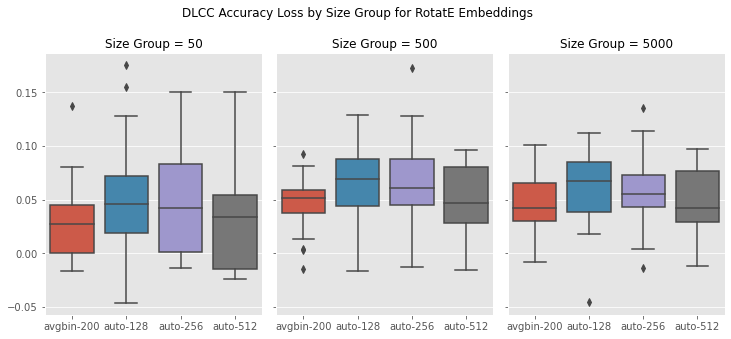

Accuracy scores for RotatE Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-rotate-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.768} &       0.675  &     0.664  &     0.666  &     0.671  \\
tc01-hard  &	\textbf{0.618} &       0.577  &     0.594  &     0.571  &     0.588  \\
tc02       &	\textbf{0.712} &       0.704  &     0.681  &     0.696  &     0.693  \\
tc02-hard  &	\textbf{0.649} &       0.566  &     0.573  &     0.585  &     0.570  \\
tc03       &	\textbf{0.780} &       0.705  &     0.694  &     0.706  &     0.705  \\
tc04       &	\textbf{0.862} &       0.828  &     0.795  &     0.806  &     0.819  \\
tc04-hard  &	\textbf{0.789} &       0.737  &     0.704  &     0.710  &     0.726  \\
tc05       &	\textbf{0.802} &       0.740  &     0.723  &     0.667  &     0.704  \\
tc06       &	\textbf{0.866} &       0.819  &     0.788  &  

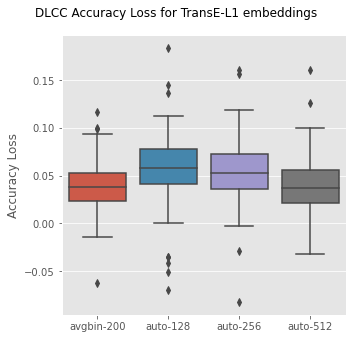

DLCC Accuracy Loss by Size Group for TransE-L1 Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-transe-l1}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-transe-l1.png}}
    \caption{DLCC Accuracy Loss by Size Group for TransE-L1 Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-transe-l1}
\end{figure}


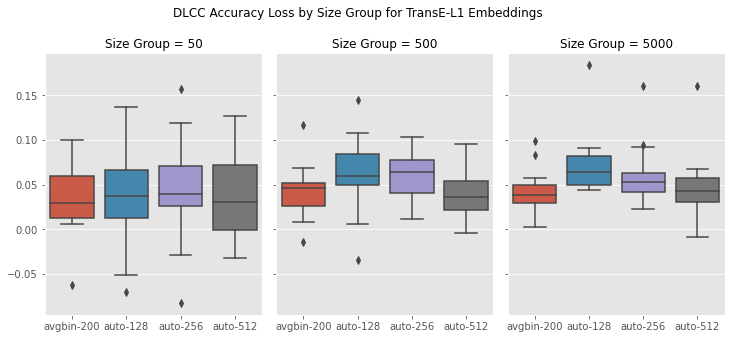

Accuracy scores for TransE-L1 Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-transe-l1-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.842} &       0.795  &     0.774  &     0.792  &     0.797  \\
tc01-hard  &	\textbf{0.799} &       0.716  &     0.714  &     0.733  &     0.739  \\
tc02       &	\textbf{0.854} &       0.815  &     0.782  &     0.795  &     0.813  \\
tc02-hard  &	\textbf{0.780} &       0.732  &     0.732  &     0.757  &     0.752  \\
tc03       &	\textbf{0.819} &       0.786  &     0.773  &     0.773  &     0.773  \\
tc04       &	\textbf{0.932} &       0.904  &     0.866  &     0.879  &     0.887  \\
tc04-hard  &	\textbf{0.818} &       0.760  &     0.734  &     0.723  &     0.755  \\
tc05       &	\textbf{0.865} &       0.834  &     0.807  &     0.803  &     0.797  \\
tc06       &	\textbf{0.928} &       0.889  &     0.83

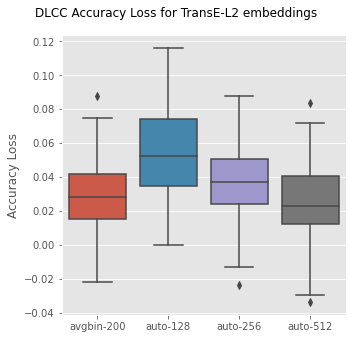

DLCC Accuracy Loss by Size Group for TransE-L2 Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-transe-l2}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-transe-l2.png}}
    \caption{DLCC Accuracy Loss by Size Group for TransE-L2 Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-transe-l2}
\end{figure}


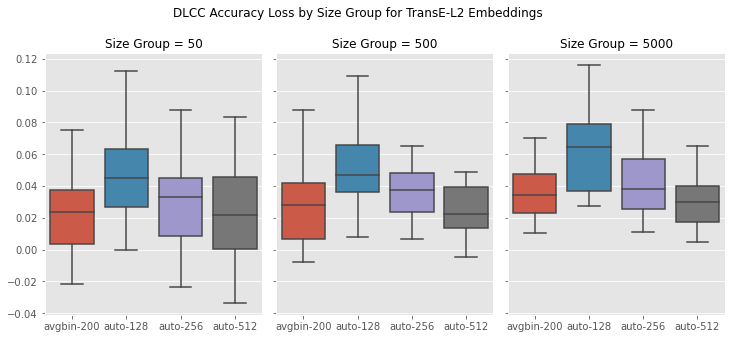

Accuracy scores for TransE-L2 Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-transe-l2-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.948} &       0.898  &     0.871  &     0.889  &     0.909  \\
tc01-hard  &	\textbf{0.918} &       0.882  &     0.843  &     0.870  &     0.895  \\
tc02       &	\textbf{0.973} &       0.928  &     0.879  &     0.917  &     0.936  \\
tc02-hard  &	\textbf{0.873} &       0.838  &     0.776  &     0.799  &     0.821  \\
tc03       &	\textbf{0.932} &       0.883  &     0.851  &     0.867  &     0.882  \\
tc04       &	\textbf{0.987} &       0.968  &     0.954  &     0.962  &     0.968  \\
tc04-hard  &	\textbf{0.909} &       0.839  &     0.797  &     0.822  &     0.844  \\
tc05       &	\textbf{0.949} &       0.915  &     0.899  &     0.912  &     0.917  \\
tc06       &	\textbf{0.984} &       0.965  &     0.94

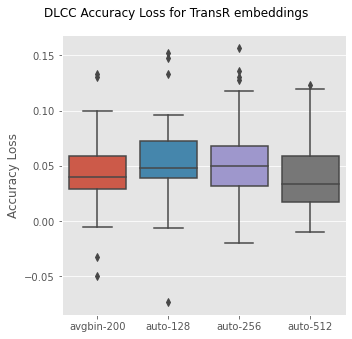

DLCC Accuracy Loss by Size Group for TransR Embeddings in Figure \ref{fig:dlcc-acc-loss-sizegroup-transr}.

\begin{figure}[h!]
    \centering
    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-transr.png}}
    \caption{DLCC Accuracy Loss by Size Group for TransR Embeddings}
    \label{fig:dlcc-acc-loss-sizegroup-transr}
\end{figure}


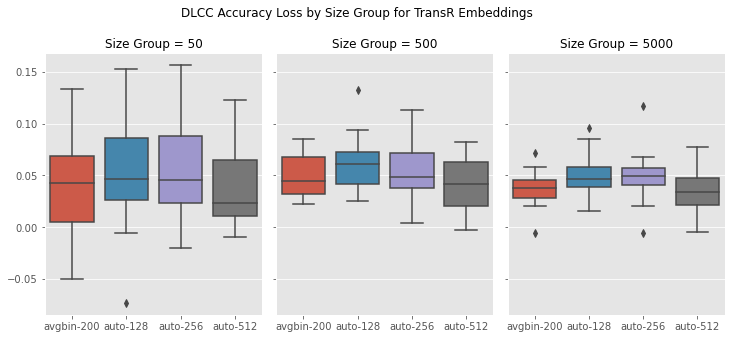

Accuracy scores for TransR Embeddings in all test collections of size 5000 in table \ref{tab:dlcc-acc-transr-5000}.


\begin{table}[h!]
\centering
\begin{tabular}{lrrrrr}
\toprule
{} &  original-200 &  avgbin-200 &  auto-128 &  auto-256 &  auto-512 \\
\midrule
tc01       &	\textbf{0.855} &       0.802  &     0.799  &     0.807  &     0.823  \\
tc01-hard  &	\textbf{0.748} &       0.689  &     0.652  &     0.630  &     0.670  \\
tc02       &	\textbf{0.834} &       0.792  &     0.796  &     0.780  &     0.795  \\
tc02-hard  &	\textbf{0.715} &       0.692  &     0.638  &     0.649  &     0.685  \\
tc03       &	\textbf{0.854} &       0.825  &     0.810  &     0.805  &     0.819  \\
tc04       &	\textbf{0.972} &       0.936  &     0.925  &     0.929  &     0.947  \\
tc04-hard  &	\textbf{0.847} &       0.776  &     0.793  &     0.784  &     0.793  \\
tc05       &	\textbf{0.881} &       0.848  &     0.851  &     0.831  &     0.834  \\
tc06       &	\textbf{0.975} &       0.940  &     0.936  &  

In [18]:
emb_types_ordered = [
    'RDF2vec$_{CBOW}$',
    'RDF2vec$_{CBOW-OA}$',
    'RDF2vec$_{SG}$',
    'RDF2vec$_{SG-OA}$', 
    'ComplEx', 
    'DistMult', 
    'RESCAL', 
    'RotatE', 
    'TransE-L1',
    'TransE-L2', 
    'TransR',
]

for embedding_type in emb_types_ordered: #df_bestscores['embedding_type'].unique():
    embedding_type_lower = str.lower(embedding_type).replace("_", "-")
    embedding_type_lower = embedding_type_lower.replace("{", "")
    embedding_type_lower = embedding_type_lower.replace("}", "")
    embedding_type_lower = embedding_type_lower.replace("$", "")
    
    print("\subsubsection{"+embedding_type+"}")
    print("\label{subsubsec:dlcc-results-"+embedding_type_lower+"} \n")
    
    g = sns.catplot(
        data=df_bestscores[
            (df_bestscores["embedding_variant"]!="original-200")
            & (df_bestscores["embedding_type"]==embedding_type)
        ], 
        x="embedding_variant", 
        y="acc_loss",
        kind="box",
        order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
    )

    g.set_axis_labels("", "Accuracy Loss")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'DLCC Accuracy Loss for {embedding_type} embeddings')
    
    plt.savefig(f"assets/dlcc-acc-loss-{embedding_type_lower}.png")
    
    print("DLCC Accuracy Loss (all Size Groups) for "+embedding_type+" Embeddings in Figure \\ref{fig:dlcc-acc-loss-"+embedding_type_lower+"}.\n")
    print("\\begin{figure}[h!]")
    print("    \centering")
    print("    \includegraphics[width=0.85\\linewidth]{assets/dlcc-acc-loss-"+embedding_type_lower+".png}")
    print("    \caption{DLCC Accuracy Loss for "+embedding_type+" Embeddings}")
    print("    \label{fig:dlcc-acc-loss-"+embedding_type_lower+"}")
    print("\end{figure}\n")
    
    plt.show()
    
    g = sns.catplot(
        data=df_bestscores[
            (df_bestscores["embedding_variant"]!="original-200")
            & (df_bestscores["embedding_type"]==embedding_type)
        ], 
        x="embedding_variant", 
        y="acc_loss",
        kind="box",
        col="Size Group",
        order=["avgbin-200", "auto-128", "auto-256", "auto-512"],
        aspect=0.7,
    )

    g.set_axis_labels("", "")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f'DLCC Accuracy Loss by Size Group for {embedding_type} Embeddings')
    
    plt.savefig(f"assets/dlcc-acc-loss-sizegroup-{embedding_type_lower}.png")
    
    print("DLCC Accuracy Loss by Size Group for "+embedding_type+" Embeddings in Figure \\ref{fig:dlcc-acc-loss-sizegroup-"+embedding_type_lower+"}.\n")
    print("\\begin{figure}[h!]")
    print("    \centering")
    print("    \centerline{\includegraphics[width=1.45\linewidth]{assets/dlcc-acc-loss-sizegroup-"+embedding_type_lower+".png}}")
    print("    \caption{DLCC Accuracy Loss by Size Group for "+embedding_type+" Embeddings}")
    print("    \label{fig:dlcc-acc-loss-sizegroup-"+embedding_type_lower+"}")
    print("\end{figure}")
    
    plt.show()
    
    # for group_size in [50, 500, 5000]:
    group_size=5000
    latex_table_print = highlight_best_scores(
        reorganize_latex_table(
            get_latex_table_acc(embedding_type, group_size)
        )
    )

    print("Accuracy scores for "+embedding_type+" Embeddings in all test collections of size 5000 in table \\ref{tab:dlcc-acc-"+embedding_type_lower+"-5000}.\n\n")

    print(latex_table_print + "\n\n")